In [29]:
import ee
import requests

# Initialize Earth Engine
ee.Initialize()

# Define the AOI
aoi_obuasi = ee.Geometry.Polygon([
    [-1.9445322, 6.2344301],  
    [-1.8541322, 6.2344301],  
    [-1.8541322, 6.1446301],  
    [-1.9445322, 6.1446301]   
])


# Function to split AOI into grid tiles
def create_grid(aoi, dx, dy):
    x_min, y_min, x_max, y_max = aoi.bounds().getInfo()['coordinates'][0][0][0], \
                                 aoi.bounds().getInfo()['coordinates'][0][0][1], \
                                 aoi.bounds().getInfo()['coordinates'][0][2][0], \
                                 aoi.bounds().getInfo()['coordinates'][0][2][1]
    
    lon_steps = int((x_max - x_min) / dx) + 1
    lat_steps = int((y_max - y_min) / dy) + 1
    
    polygons = []
    for i in range(lon_steps):
        for j in range(lat_steps):
            x0 = x_min + i * dx
            x1 = min(x0 + dx, x_max)
            y0 = y_min + j * dy
            y1 = min(y0 + dy, y_max)
            polygon = ee.Geometry.Polygon([
                [x0, y0],
                [x0, y1],
                [x1, y1],
                [x1, y0]
            ])
            polygons.append(polygon)
    return polygons

# Split the AOI into tiles
tiles = create_grid(aoi_obuasi, dx=0.05, dy=0.05)
print(f"Number of tiles created: {len(tiles)}")

# Prepare the composite image (as before)
def mask_clouds(image):
    qa = image.select('QA60')
    cloud_mask = qa.bitwiseAnd(1 << 10).eq(0)
    cirrus_mask = qa.bitwiseAnd(1 << 11).eq(0)
    return image.updateMask(cloud_mask).updateMask(cirrus_mask)

# Sentinel-2 data collection for the AOI
sentinel2_training = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(aoi_obuasi) \
    .filterDate('2024-01-01', '2024-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)) \
    .map(mask_clouds)

# Select relevant bands for training (RGB + NIR)
sentinel2_bands_training = sentinel2_training.select(['B4', 'B3', 'B2', 'B8'])

# Generate median composite for the training data region
composite_training = sentinel2_bands_training.median()

# Visualization parameters for RGB
visualization_params_training = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']  # RGB bands
}

# List to store the URLs
download_urls = []

# Loop through each tile and generate the download URL
for idx, tile in enumerate(tiles):
    try:
        url = composite_training.getThumbURL({
            'region': tile,
            'scale': 10,  # 10m resolution
            'format': 'GEO_TIFF',
            'crs': 'EPSG:4326',  # Ensure CRS consistency
            #'filePerBand': False  # Download all bands in a single GeoTIFF
            **visualization_params_training
        })
        download_urls.append((idx, url))
        print(f"Download URL for tile {idx}: {url}")
    except Exception as e:
        print(f"Error generating URL for tile {idx}: {e}")

# Optionally, download the images programmatically
for idx, url in download_urls:
    response = requests.get(url)
    if response.status_code == 200:
        # Save the image to a file
        with open(f'tile_{idx}.tif', 'wb') as f:
            f.write(response.content)
        print(f"Downloaded tile_{idx}.tif")
    else:
        print(f"Failed to download tile {idx}")


Number of tiles created: 4
Download URL for tile 0: https://earthengine.googleapis.com/v1/projects/243091818257/thumbnails/27ff55dbdfaa5415af954f3ea4ef885b-fe3978fbebbe30cc0c87699f7d587fce:getPixels
Download URL for tile 1: https://earthengine.googleapis.com/v1/projects/243091818257/thumbnails/080c5d5cbede332bd726eee2dbce2135-02ef23c91f0bfaf308d890d81a83565a:getPixels
Download URL for tile 2: https://earthengine.googleapis.com/v1/projects/243091818257/thumbnails/b52451f72e4308f584d634757eee4332-a29655263ef6f9eff80c0a9888b485c7:getPixels
Download URL for tile 3: https://earthengine.googleapis.com/v1/projects/243091818257/thumbnails/f8b260fe69e43b89e17cca308d6cf62a-f3d5a10eac89c4c475a379bfe5b44aa0:getPixels
Downloaded tile_0.tif
Downloaded tile_1.tif
Downloaded tile_2.tif
Downloaded tile_3.tif


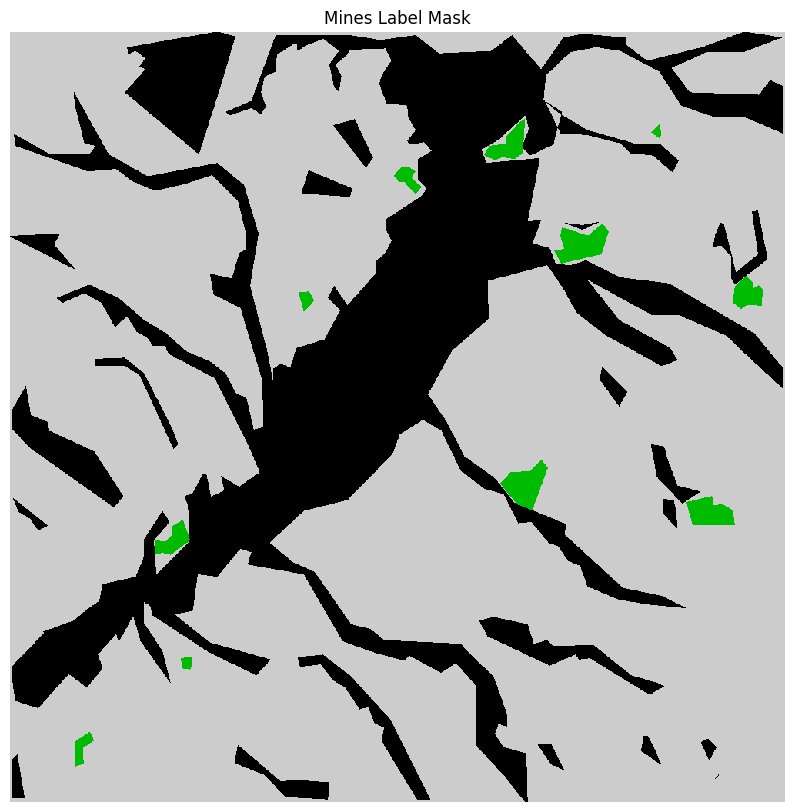

Unique values in label mask: [1 2 3]


In [39]:
import rasterio
import matplotlib.pyplot as plt

# Path to the rasterized label mask
label_mask_path = 'labels.tif'

# Load the label mask
with rasterio.open(label_mask_path) as src:
    label_mask = src.read(1)  # Read the first (and only) band
    mask_meta = src.meta

# Display the label mask
plt.figure(figsize=(10, 10))
plt.imshow(label_mask, cmap='nipy_spectral', interpolation='nearest')
plt.title('Mines Label Mask')
plt.axis('off')
plt.show()

# Check unique values in the label mask (should be 0 and 1)
import numpy as np
print("Unique values in label mask:", np.unique(label_mask))


Satellite Image Shape: (3, 1001, 1007)
Label Mask Shape: (1001, 1007)
Features Shape: (1001, 1007, 3)
Labels Shape: (1001, 1007)
Unique label values before adjustment: [1 2 3]
Labels adjusted to start from 0.
Unique label values after adjustment: [0 1 2]
Number of Classes: 3
Total Patches: 49
Each Patch Feature Shape: (256, 256, 3)
Each Patch Label Shape: (256, 256)
Labels after processing: (49, 256, 256, 3)
X_train shape: (39, 256, 256, 3)
X_test shape: (10, 256, 256, 3)
y_train shape: (39, 256, 256, 3)
y_test shape: (10, 256, 256, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_15[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_19[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_21[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 768)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │  1,769,728 │ concatenate_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ conv2d_24[0][0] 

 Total params: 7,783,043 (29.69 MB)

 Trainable params: 7,783,043 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 54s 15s/step - accuracy: 0.1850 - loss: 1.1114 - val_accuracy: 0.7282 - val_loss: 1.0833
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 14s/step - accuracy: 0.7051 - loss: 1.0773 - val_accuracy: 0.7261 - val_loss: 1.0342
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 14s/step - accuracy: 0.7015 - loss: 1.0152 - val_accuracy: 0.7273 - val_loss: 0.8698
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 14s/step - accuracy: 0.7277 - loss: 0.8537 - val_accuracy: 0.7273 - val_loss: 0.7772
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 15s/step - accuracy: 0.7165 - loss: 0.8013 - val_accuracy: 0.7273 - val_loss: 0.7125
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 15s/step - accuracy: 0.7141 - loss: 0.7378 - val_accuracy: 0.7273 - val_loss: 0.7023
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - accuracy: 0.7273 - loss: 0.7161 - val_accuracy: 0.7273 - val_loss: 0.6702
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 15s/step - accuracy: 0.7270 - loss: 0.7039 - val_accuracy: 0.7273 - val_loss: 0.6630


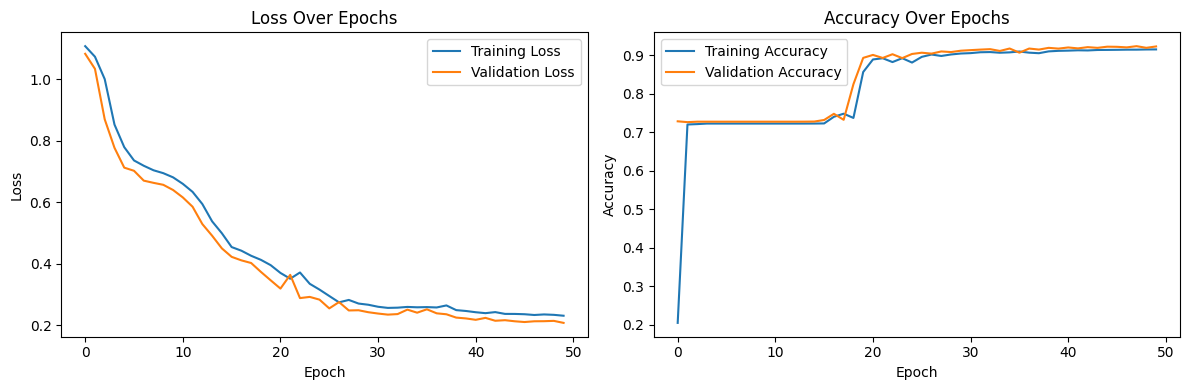

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


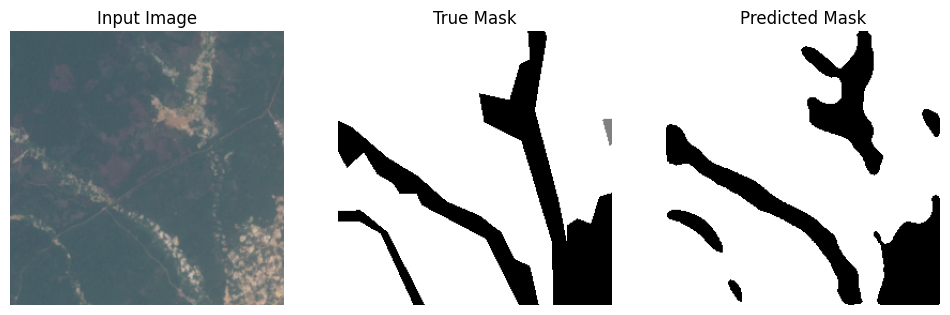

In [50]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

# -------------------------------
# 1. Data Loading and Preprocessing
# -------------------------------

# File paths
sat_image_path = 'satellite_image.tif'  # Update this to your satellite image path
label_mask_path = 'labels.tif'          # Update this to your label mask path

# Load the satellite image
with rasterio.open(sat_image_path) as src:
    satellite_image = src.read()        # Read all bands of the satellite image
    sat_meta = src.meta

# Load the label mask
with rasterio.open(label_mask_path) as src:
    label_mask = src.read(1)            # Read the first (and only) band of the label mask
    mask_meta = src.meta

# Check shapes of satellite image and label mask
print('Satellite Image Shape:', satellite_image.shape)  # e.g., (3, 1001, 1007)
print('Label Mask Shape:', label_mask.shape)            # e.g., (1001, 1007)

# Transpose satellite image to (height, width, bands)
features = np.transpose(satellite_image, (1, 2, 0))   # Shape: (1001, 1007, 3)
labels = label_mask                                   # Shape: (1001, 1007)

# Display the shapes
print('Features Shape:', features.shape)
print('Labels Shape:', labels.shape)

# Normalize the satellite image
features = features.astype('float32') / 255.0

# Identify the number of classes from the label mask
unique_labels = np.unique(labels)
print("Unique label values before adjustment:", unique_labels)

# Adjust labels to start from 0 if they start from 1
if unique_labels.min() == 1:
    labels = labels - 1
    print("Labels adjusted to start from 0.")
else:
    print("Labels already start from 0.")

# Recompute unique labels after adjustment
unique_labels = np.unique(labels)
print("Unique label values after adjustment:", unique_labels)

num_classes = len(unique_labels)
print('Number of Classes:', num_classes)

# -------------------------------
# 2. Creating Image Patches with Overlap
# -------------------------------

def create_patches(features, labels, patch_size=256, overlap=128):
    """
    Splits the features and labels into overlapping patches.
    """
    patches_features = []
    patches_labels = []
    h, w, _ = features.shape

    step = patch_size - overlap
    for i in range(0, h - patch_size + 1, step):
        for j in range(0, w - patch_size + 1, step):
            patch_feat = features[i:i+patch_size, j:j+patch_size, :]
            patch_lbl = labels[i:i+patch_size, j:j+patch_size]
            patches_features.append(patch_feat)
            patches_labels.append(patch_lbl)
    
    # Handle the right and bottom edges
    for i in range(0, h - patch_size + 1, step):
        j = w - patch_size
        patch_feat = features[i:i+patch_size, j:j+patch_size, :]
        patch_lbl = labels[i:i+patch_size, j:j+patch_size]
        patches_features.append(patch_feat)
        patches_labels.append(patch_lbl)
    
    for j in range(0, w - patch_size + 1, step):
        i = h - patch_size
        patch_feat = features[i:i+patch_size, j:j+patch_size, :]
        patch_lbl = labels[i:i+patch_size, j:j+patch_size]
        patches_features.append(patch_feat)
        patches_labels.append(patch_lbl)
    
    # Bottom-right corner
    patch_feat = features[h - patch_size:h, w - patch_size:w, :]
    patch_lbl = labels[h - patch_size:h, w - patch_size:w]
    patches_features.append(patch_feat)
    patches_labels.append(patch_lbl)
    
    return np.array(patches_features), np.array(patches_labels)

# Create patches with overlap
patch_size = 256
overlap = 128  # 50% overlap
X, Y = create_patches(features, labels, patch_size, overlap)

print('Total Patches:', X.shape[0])
print('Each Patch Feature Shape:', X.shape[1:])
print('Each Patch Label Shape:', Y.shape[1:])

# -------------------------------
# 3. Preparing Labels
# -------------------------------

# If it's multi-class segmentation, convert labels to categorical
if num_classes > 2:
    Y = to_categorical(Y, num_classes=num_classes)
else:
    # For binary segmentation, you might keep it as is or expand dims
    Y = np.expand_dims(Y, axis=-1)

print('Labels after processing:', Y.shape)

# -------------------------------
# 4. Train-Test Split
# -------------------------------

# Split the patches into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# -------------------------------
# 5. Defining the U-Net Model
# -------------------------------

def unet(input_shape=(256, 256, 3), num_classes=3):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # Output layer
    if num_classes > 2:
        activation = 'softmax'
    else:
        activation = 'sigmoid'
    
    outputs = layers.Conv2D(num_classes, (1, 1), activation=activation)(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate the model with correct input shape and number of classes
model = unet(input_shape=(patch_size, patch_size, 3), num_classes=num_classes)

# -------------------------------
# 6. Model Compilation
# -------------------------------

if num_classes > 2:
    loss = 'categorical_crossentropy'
    metrics = ['accuracy']
else:
    loss = 'binary_crossentropy'
    metrics = ['accuracy']

model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss, metrics=metrics)

model.summary()

# -------------------------------
# 7. Model Training
# -------------------------------

# Define callbacks (adjusted filepath to end with .keras)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_model.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=callbacks
)

# -------------------------------
# 8. Model Evaluation
# -------------------------------

# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy (if applicable)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# 9. Making Predictions
# -------------------------------

# Example: Predict on a new patch (here, using a test patch)
predictions = model.predict(X_test)

# If using softmax, take the argmax
if num_classes > 2:
    predictions = np.argmax(predictions, axis=-1)
    y_true = np.argmax(y_test, axis=-1)
elif num_classes == 2:
    predictions = (predictions > 0.5).astype(np.int)
    y_true = y_test.squeeze()
else:
    predictions = predictions.squeeze()
    y_true = y_test.squeeze()



Training accuracy 0.9148
Validation accuracy: 0.9225


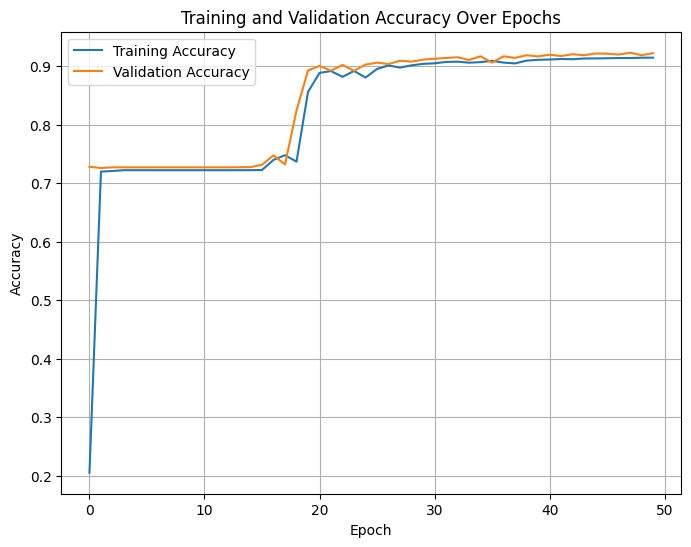

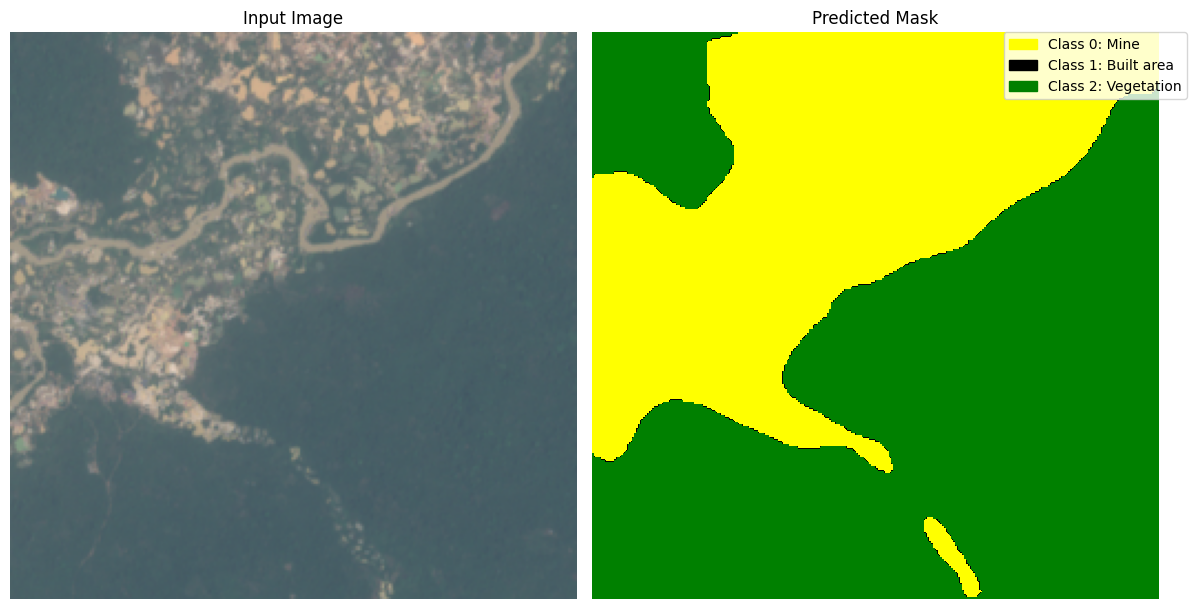

In [85]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# 1. Printing Training and Validation Accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print(f"Training accuracy {training_accuracy[-1]:.4f}")
print(f"Validation accuracy: {validation_accuracy[-1]:.4f}")

# Plotting the accuracies
plt.figure(figsize=(8, 6))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 2. Visualizing Multi-Class Predictions

# Define a color map for the classes (adjust as per the number of classes)
cmap = ListedColormap(['yellow', 'black', 'green'])  # Example: 3 classes

# Define the class names corresponding to each color
class_names = ['Class 0: Mine', 'Class 1: Built area', 'Class 2: Vegetation']

# Choose a sample index to visualize
sample_idx = 6  # Change the index to visualize other images

# Extract the sample image and predicted mask
input_image = X_test[sample_idx]      # The test image
pred_mask = predictions[sample_idx]   # The predicted mask

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

# Plot the input image and predicted mask side by side
plt.figure(figsize=(12, 6))

# Plot the input image
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(input_image)
plt.axis('off')

# Plot the predicted mask with color mapping
plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(pred_mask, cmap=cmap, vmin=0, vmax=2)  # Assuming 3 classes
plt.axis('off')

# Add a legend showing class colors
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)

plt.tight_layout()
plt.show()